In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timezone
from time import time, ctime, struct_time, gmtime

import os

import matplotlib as mpl

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def init_plot_simple():
    fig, axs = plt.subplots(1,1)
    fig.set_size_inches(12, 4)
    return fig, axs

In [3]:
def init_plot():
    proj = ccrs.PlateCarree(central_longitude=180)
    #datacrs = ccrs.PlateCarree()
    fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': proj})
    fig.set_size_inches(6, 8)
    return fig, axs

In [4]:
def finalize_plot(fig, pdict):
    
    now = datetime.now()
    print("now =", now)
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("date and time =", dt_string)	

    plotdir = pdict.get('plotdir')
    cstype = pdict.get('cstype')
    
    if pdict.get('zoom'):
        pdict['gxfpath'] = plotdir + '/' + 'vars_panel_' + '_zoom.png'
    else:
        pdict['gxfpath'] = plotdir + '/' + 'mrms_' + pdict.get('dtstr') + '.png'
    
    #pdict['myname'] = os.path.basename(os.path.abspath(__file__))
    pdict['myname'] = 'mrms'
    pdict['xtime'] = dt_string
    
    #fig.suptitle(pdict.get('stitle'))
    
    mstr = pdict.get('myname') + ' [' + pdict.get('xtime') + ']'
    plt.gcf().text(0.1, 0.02, mstr, fontsize=8)

    pngfile = pdict.get('gxfpath')
    plt.savefig(pngfile, dpi=72, bbox_inches='tight', pad_inches=0.5)
    
    plt.show()

In [5]:
def mkplot_simple(fig, ax, pdict):
    
    lat = pdict.get('lat')
    lon = pdict.get('lon')
    lon2d, lat2d = np.meshgrid(lon, lat)
    
    data = pdict.get('data')
    xvec = pdict.get('xvec')
    xlabel = pdict.get('xlabel')
    
    print(data.shape)
    
    plt.subplots_adjust(hspace=0.3)
    cs = ax.contourf(lon2d, lat2d, data, 
            pdict.get('cm_def'), cmap=pdict.get('cmap') )
    
    ax.set_title('{0} ({1})'.format(pdict.get('vlongname'), 
                 pdict.get('vunits')), loc='left')
    fig.colorbar(cs, ax=ax, orientation='vertical')
    
    return

In [6]:
def mkplot(fig, ax, pdict):

    proj = ccrs.PlateCarree(central_longitude=180)
    datacrs = ccrs.PlateCarree()

    lat = pdict.get('lat')
    lon = pdict.get('lon')
    lon2d, lat2d = np.meshgrid(lon, lat)


    data = pdict.get('data')

    print(np.min(data))
    print(np.max(data))
    #print(data.shape)
    
    plt.subplots_adjust(hspace=0.3)
    cs = ax.contourf(lon2d, lat2d, data, pdict.get('cm_def'), cmap=pdict.get('cmap'), \
                     transform=datacrs, extend='neither')
    #ax.coastlines(resolution='110m', linewidth=1.0, color='k')

    if pdict.get('xticks_on'):
        #xticks = pdict.get('xticks')
        xticks = pdict.get('xticks')
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())

    if pdict.get('yticks_on'):
        #yticks = [0, 10, 20, 30]
        yticks = pdict.get('yticks')
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_title('{0} ({1})'.format(pdict.get('vname'),
                 pdict.get('vunits')), loc='left')
    ax.set_title(pdict.get('dtstr'), loc='right')
    fig.colorbar(cs, ax=ax, orientation='horizontal', \
                 ticks=pdict.get('cticks'), \
                 fraction=pdict.get('cb_fraction'), \
                 pad=pdict.get('cb_pad'))

    return

In [7]:
def get_coords(fpath, pdict):
    
    fh = Dataset(fpath, mode='r')
    pdict['lat'] = fh.variables['latitude'][:]
    pdict['lon'] = fh.variables['longitude'][:]
    
    return pdict

In [8]:
def get_var(fpath, vname, xdict):

    fh = Dataset(fpath, mode='r')
    var = np.squeeze( fh.variables[vname][:] )
    
    xdict['data'] = np.squeeze(var) * 24 # mm/day
    xdict['xvec'] = xdict.get('lon')
    xdict['yvec'] = xdict.get('lat')
    xdict['xlabel'] = 'longitude'
    xdict['ylabel'] = 'latitude'
    xdict['stitle'] = 'Precipitation Rate'
    
    xdict['vlongname'] = fh.variables[vname].getncattr('long_name')
    xdict['vunits'] = fh.variables[vname].getncattr('units')
    xdict['vname'] = vname
    
    return xdict

In [9]:
def get_config():
    
    datadir = "../data/daily"
    plotdir = "./scratch"
    cdict = {}
    cdict['datadir'] = datadir
    cdict['plotdir'] = plotdir
    cdict['cm_def'] = np.linspace(0, 300, 41, endpoint=True)
    cdict['cticks'] = [0, 150, 300]
    cdict['cb_fraction'] = 0.038
    cdict['cb_pad'] = 0.05
    cdict['cmap'] = 'gist_ncar_r'
    
    return cdict

In [10]:
def main():
    
    
    pdict = get_config()
    
    stime = datetime(2005, 8, 12, 0, 0, tzinfo=timezone.utc)
    etime = datetime(2005, 8, 17, 0, 0, tzinfo=timezone.utc)
    dstep = 24*60*60
    ts = stime.timestamp()
    while ts <= etime.timestamp():
        
        dt = datetime.utcfromtimestamp(ts)
        print( dt.strftime("%Y-%m-%d %H:%M:%S") )
        
        dtstr = dt.strftime("%Y%m%d")
        pdict['dtstr'] = dtstr
        print("dtstr = ", dtstr)
        
        fpath = pdict.get('datadir') + '/' + 'MRMS_PrecipRate_00.00_' + dtstr + '.tm.nc'    
        xs = get_coords(fpath, pdict)
        fig, axs = init_plot()
        get_var(fpath, 'PrecipRate_surface', pdict)
        mkplot(fig, axs, pdict)
        finalize_plot(fig, pdict)
        
        ts += dstep   
    
    return

2005-08-12 00:00:00
dtstr =  20050812
0.0
247.25162
now = 2021-07-21 15:20:11.741853
date and time = 21/07/2021 15:20:11


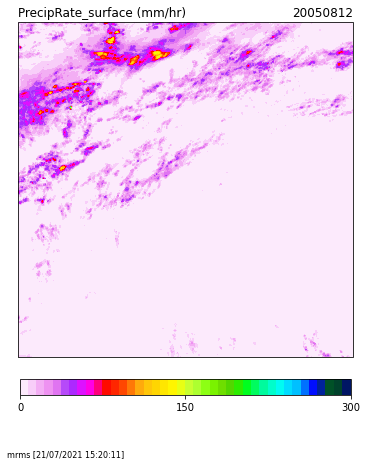

2005-08-13 00:00:00
dtstr =  20050813
0.0
365.05682
now = 2021-07-21 15:20:21.020417
date and time = 21/07/2021 15:20:21


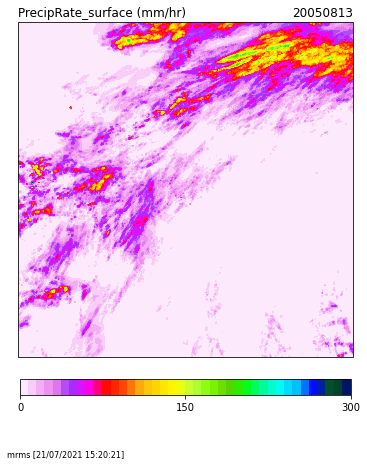

2005-08-14 00:00:00
dtstr =  20050814
0.0
491.05835
now = 2021-07-21 15:20:38.978654
date and time = 21/07/2021 15:20:38


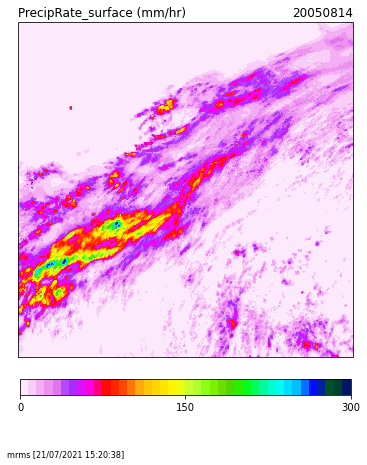

2005-08-15 00:00:00
dtstr =  20050815
0.0
258.97498
now = 2021-07-21 15:20:58.882484
date and time = 21/07/2021 15:20:58


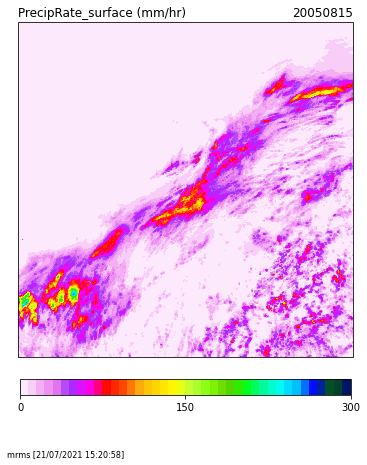

2005-08-16 00:00:00
dtstr =  20050816
0.0
416.41052
now = 2021-07-21 15:21:15.506037
date and time = 21/07/2021 15:21:15


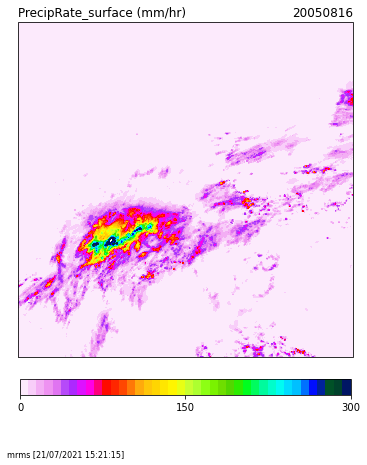

2005-08-17 00:00:00
dtstr =  20050817
0.0
175.2803
now = 2021-07-21 15:21:28.464905
date and time = 21/07/2021 15:21:28


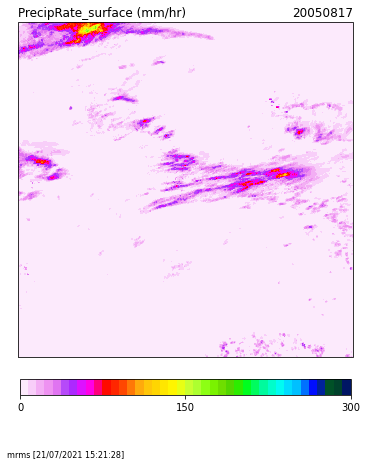

In [11]:
if __name__ == "__main__":
    main()